Generating supporting files for ReLERNN

In [1]:
%run ../scripts/notebook_settings_lean.py
import glob

/faststorage/project/baboondiversity/people/eriks/second_analysis_baboons/scripts/notebook_settings_lean.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


In [2]:
relernn_dir = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/relernn_input/"

In [3]:
chrom_lengths = pd.read_csv("/home/eriks/baboondiversity/data/callability_panu3_26_04_2021/genome_lengths",
            sep="\t", names=["chrom", "length"])

In [4]:
chrom_lengths["start"] = 0
chrom_lengths = chrom_lengths[["chrom", "start", "length"]]

In [5]:
chrom_lengths.iloc[:-1]

,chrom,start,length
0,chr1,0,217458864
1,chr2,0,188283584
2,chr3,0,181338541
3,chr4,0,166074386
4,chr5,0,183742232
5,chr6,0,175400206
6,chr7,0,162899863
7,chr8,0,140346614
8,chr9,0,125784921
9,chr10,0,91330067


In [6]:
chrom_lengths.iloc[:-1].to_csv(relernn_dir + "autosome_sizes.bed", sep="\t", index=False, header=False)
chrom_lengths.iloc[-1:].to_csv(relernn_dir + "chrX_sizes.bed", sep="\t", index=False, header=False)

Creating sample ID lists to filter pops for.

In [7]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
meta_data_samples_Sci = meta_data_samples.copy()
for i, row in meta_data_samples_Sci.iterrows():
    if row.PGDP_ID[0] != "P":
        meta_data_samples_Sci.at[i, "PGDP_ID"] = "Sci_"+str(row.PGDP_ID)

In [8]:
for o in meta_data_samples_Sci.Origin.unique():
    pop_subset = meta_data_samples_Sci.loc[meta_data_samples_Sci.Origin == o]
    print(o, len(pop_subset))

Mikumi, Tanzania 38
Aberdare, Kenya 2
Chunga, Zambia 27
captive 2
Awash, Ethiopia 2
Serengeti, Tanzania 14
Arusha, Tanzania 4
Ngorongoro, Tanzania 6
Ruaha, Tanzania 6
Gombe, Tanzania 17
Udzungwa, Tanzania 5
Mahale, Tanzania 7
Katavi, Tanzania 2
Selous, Tanzania 3
Lake Manyara, Tanzania 19
Tarangire, Tanzania 7
Niokolo-Koba, Senegal 12
Issa Valley, Tanzania 1
Dendro Park, Zambia 4
Filoha, Ethiopia 24
Gog Woreda, Gambella region, Ethiopia 25


In [9]:
for o in meta_data_samples_Sci.Origin.unique():
    pop_subset = meta_data_samples_Sci.loc[meta_data_samples_Sci.Origin == o]
    short_origin = o.replace(" ", ",").split(",")[0]
    pop_subset[["PGDP_ID"]].to_csv(relernn_dir + short_origin + ".sample_list.txt",
                                          header=False, index=False, sep="\t")

Checking access mask

In [10]:
mask = pd.read_csv(relernn_dir + "autosomes.sorted.bed", sep="\t", names=["chrom", "start", "end"])

In [11]:
fixed_mask = mask.loc[~((mask.start == 0) & (mask.end > 50000))]

In [12]:
#fixed_mask.to_csv(relernn_dir + "autosomes.sorted.bed", sep="\t", header=False, index=False)

In [13]:
fixed_mask

,chrom,start,end
0,chr1,0,73
1,chr1,74,75
2,chr1,76,77
3,chr1,80,81
4,chr1,82,89
...,...,...,...
16005244,chr20,72047499,72048329
16005245,chr20,72048358,72048359
16005246,chr20,72048403,72048774
16005247,chr20,72048781,72048782


In [14]:
window_size = 1000000
df_l = []
for chrom in fixed_mask.chrom.unique():
    print(chrom)
    chrom_bed = fixed_mask.loc[fixed_mask.chrom == chrom]
    merged_start = np.sort(np.append(np.array(chrom_bed.start), np.arange(0, chrom_bed.end.max(), window_size)))
    merged_end = np.sort(np.append(np.array(chrom_bed.end), np.arange(0, chrom_bed.end.max(), window_size)))
    chrom_ranges = pd.DataFrame({"start": merged_start, "end": merged_end})
    windows = np.arange(0, chrom_bed.end.max()+window_size, window_size)
    summed_bed = chrom_ranges.groupby(pd.cut(chrom_ranges.end,
                                              windows)).sum().reset_index(drop=True)
    summed_bed["percent_coverage"] = 1-(summed_bed.end - summed_bed.start) / window_size
    summed_bed["window"] = summed_bed.index*window_size
    summed_bed["chrom"] = chrom
    df_l.append(summed_bed)
call_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20


In [15]:
call_df

,start,end,percent_coverage,window,chrom
0,5360388040,5360559173,0.828867,0,chr1
1,12160343627,12160425163,0.918464,1000000,chr1
2,19207364518,19207450218,0.914300,2000000,chr1
3,17754424005,17754469330,0.954675,3000000,chr1
4,26261323068,26261398203,0.924865,4000000,chr1
...,...,...,...,...,...
68,440521128909,440521172866,0.956043,68000000,chr20
69,573999678945,573999756970,0.921975,69000000,chr20
70,720048925822,720049034713,0.891109,70000000,chr20
71,1299228604988,1299228797625,0.807363,71000000,chr20


<AxesSubplot:xlabel='window', ylabel='percent_coverage'>

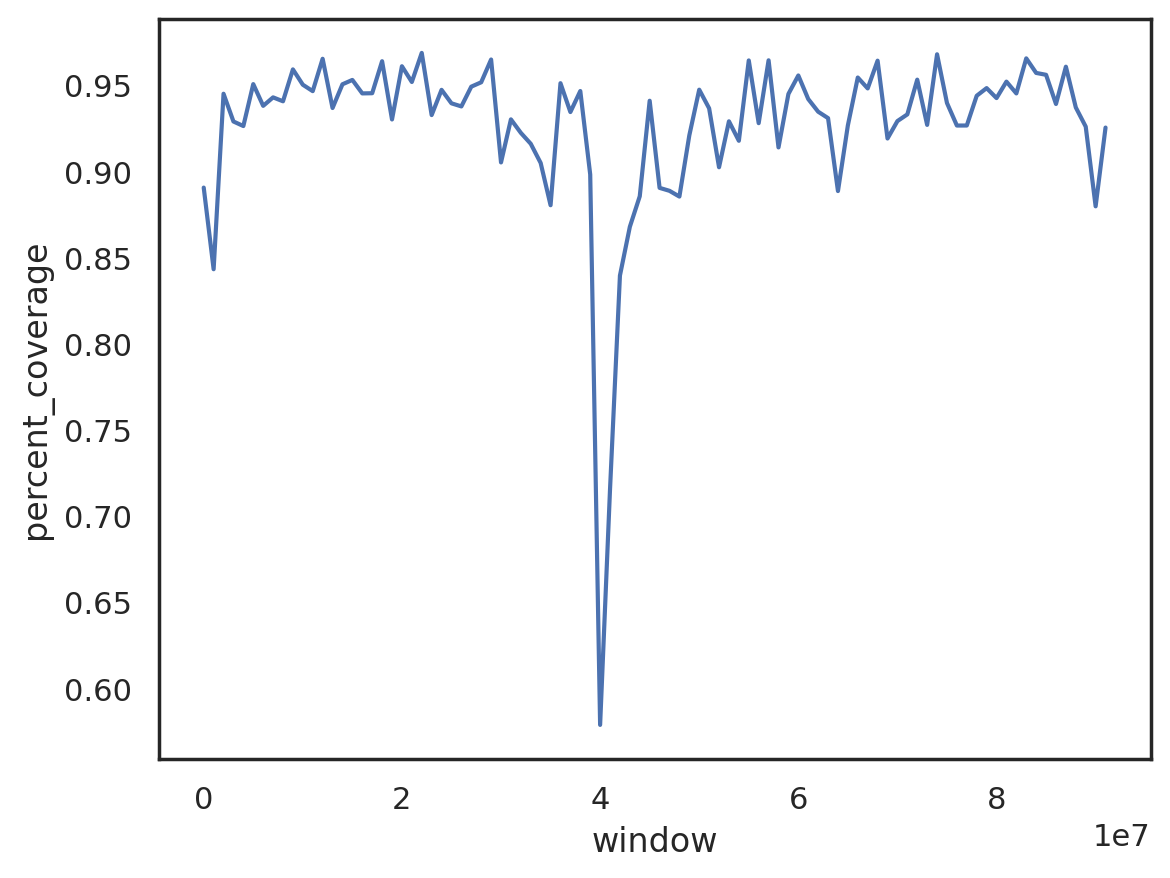

In [16]:
sns.lineplot(data=call_df.loc[call_df.chrom == "chr17"], x="window", y="percent_coverage")